# Compare Energies
Compare the energies to our baseline, determine the optimal set

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from ase.db import connect
from ase import units
import pandas as pd

## Load in the Gaussian PCM Reference Data
It's our ground truth

In [2]:
pcm_results = pd.read_csv('reference-data.csv.gz', usecols=['smiles_1', 'sol_acn'])
pcm_results = dict(zip(pcm_results['smiles_1'], pcm_results['sol_acn']))

## Load in the CP2K Data
We have both the energy of the molecule in vacuum and in solvents with different parameterizations. The script will need to use them to compute the solvation energy

In [3]:
with connect('solv-calculations.db') as db:
    # Get the energies in vacuum
    vac_energy = {}
    for row in db.select(solvent='vacuum'):
        vac_energy[row.smiles] = row.energy
        
    # Get everything else
    sccs_data = []
    for row in db.select(solvent='acn'):
        sccs_data.append({
            'smiles': row.smiles, 
            'sol_acn': row.energy - vac_energy[row.smiles],
            'sol_acn_pcm': pcm_results[row.smiles],
            'alpha': row.alpha,
            'beta': row.beta,
        })
sccs_data = pd.DataFrame(sccs_data)    

In [4]:
sccs_data['error'] = (sccs_data['sol_acn'] - sccs_data['sol_acn_pcm']).abs()

In [5]:
sccs_data.head()

,smiles,sol_acn,sol_acn_pcm,alpha,beta,error
0,[nH]1ncn2cnnc12,-0.649129,-0.848371,-29.45,-0.10,0.199242
1,[nH]1ncn2cnnc12,-0.649129,-0.848371,-29.45,-0.05,0.199242
2,[nH]1ncn2cnnc12,-0.649129,-0.848371,-29.45,0.00,0.199242
3,[nH]1ncn2cnnc12,-0.649129,-0.848371,-29.45,0.05,0.199242
4,[nH]1ncn2cnnc12,-0.649129,-0.848371,-29.45,0.10,0.199242


## Find the best $\alpha$ and $\beta$
We want to pick the values which minimize the mean absolute error from the base set

In [6]:
error_by_param = pd.DataFrame(sccs_data.groupby(['alpha', 'beta'])['error'].mean()).reset_index(level=[0, 1])

Best params are below

In [7]:
best_params = error_by_param.loc[error_by_param.error.argmin()]

## Plot the best error
Plot the enerties with the best error

In [8]:
best_results = sccs_data[(sccs_data.alpha == best_params['alpha']) & (sccs_data.beta == best_params['beta'])]
print(f'Found {len(best_results)} complete molecules')

Found 32 complete molecules


In [9]:
best_results.head()

,smiles,sol_acn,sol_acn_pcm,alpha,beta,error
0,[nH]1ncn2cnnc12,-0.649129,-0.848371,-29.45,-0.1,0.199242
25,O=CC(C#C)(C#C)C#N,-0.417634,-0.313978,-29.45,-0.1,0.103656
36,FC1=CN[C]([NH])C(=O)N1,-0.552521,-0.504272,-29.45,-0.1,0.048248
40,COc1connc1=O,-0.474422,-0.299854,-29.45,-0.1,0.174568
44,O[C@H]1C[C@H]2C[C@@H]12,-0.228328,-0.275245,-29.45,-0.1,0.046917


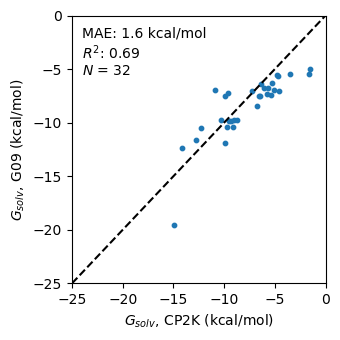

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(
    best_results['sol_acn'] * units.mol / units.kcal,
    best_results['sol_acn_pcm'] * units.mol / units.kcal,
    s=10,
)

mae = best_results['error'].mean() * units.mol / units.kcal
r2 = np.corrcoef(best_results['sol_acn'], best_results['sol_acn_pcm'])[0, 1] ** 2

ax.text(-24, -1, f'MAE: {mae:.1f} kcal/mol\n$R^2$: {r2:.2f}\n$N$ = {len(best_results)}', va='top')

ax.set_xlim(-25, 0)
ax.set_ylim(ax.get_xlim())

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_ylabel('$G_{solv}$, G09 (kcal/mol)')
ax.set_xlabel('$G_{solv}$, CP2K (kcal/mol)')

fig.tight_layout()

Our data agree within ~2 kcal/mol. I don't believe tuning $\epsilon_0$ or $\gamma$ will be necessary